In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchio as tio

import os
import json
import numpy as np
import copy
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

import yaml
from dataset.hmri_dataset import HMRIDataModule
from models.pl_model import Model
from utils.utils import get_pretrained_model
from utils.utils import save_nifti_from_array
this_path = Path().resolve()

def main():
    # subj_idx = 11
    device = 'cuda:0'
    ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/version_0/checkpoints/epoch=60-val_auroc=0.9388.ckpt')
    exp_dir = ckpt_path.parent.parent.parent
    with open(exp_dir /'config_dump.yml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

    root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
    md_df = pd.read_csv(this_path/'bids_3t.csv')
    data = HMRIDataModule(md_df=md_df, root_dir=root_dir, **cfg['dataset']) #shuffle=False

    # loading model from checkpoint
    model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])
    network = copy.deepcopy(model.net)
    network.eval()
    # create dataset
    data.prepare_data()
    data.setup()
    df = data.md_df_val

    # prediction of all
    network = network.to(device)
    preds_final = []
    preds_scores = []
    for i in range(len(df)):
        input, target = data.val_set[i]['image'][tio.DATA], data.val_set[i]['label']
        print(df.iloc[i]['id'], target)
        input = input.unsqueeze(0).to(device)

        with torch.no_grad():
            output = network(input)
            # print(f"model's logits output: {output}")
        output = F.softmax(output, dim=1)
        prediction_score, pred_label_idx = torch.topk(output, 1)
        print(pred_label_idx, prediction_score)
        preds_final.append(prediction_score.cpu().numpy()[0][0])
        preds_scores.append(pred_label_idx.cpu().numpy()[0][0])
        # break
    df['preds'] = preds_final
    df['preds_scores'] = preds_scores

    df.to_csv('preds.csv', index=False)


if __name__ == '__main__':
    main()

In [3]:
import torch
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchio as tio
import nibabel as nib
import SimpleITK as sitk

import os
import json
import numpy as np
import copy
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import LRP

import yaml
from dataset.hmri_dataset import HMRIDataModule, HMRIDataModuleDownstream
from models.pl_model import Model, ContrastiveLearning, ModelDownstream
from utils.utils import get_pretrained_model
from utils.utils import save_nifti_from_array, crop_img
from utils.general_utils import save_sitk_from_nda
this_path = Path().resolve()

### DEV

In [3]:
new_folder = Path(this_path / 'xai_outs/test_folder')
new_folder.mkdir(parents=True, exist_ok=True)

In [13]:
df = pd.read_csv('PD_R2scorr_preds.csv')
df

,id,s01-7t,s01-3t,s02-7t,s03-7t,group,sex,age,preds,preds_scores
0,sub-021,True,True,False,False,1,0,84,0.660980,1
1,sub-064,True,True,True,True,0,0,53,0.663953,1
2,sub-042,True,True,True,True,1,0,52,0.697890,1
3,sub-066,True,True,False,False,1,1,74,0.669280,1
4,sub-041,True,True,True,True,1,0,51,0.666254,1
5,sub-019,True,True,True,True,1,1,73,0.674259,1
6,sub-036,True,True,True,True,0,0,59,0.644940,1
7,sub-039,True,True,False,False,1,0,79,0.682424,1
8,sub-035,True,True,True,True,1,0,64,0.722197,1
9,sub-071,True,True,True,True,1,0,66,0.700894,1


In [2]:
subj_idx = 11
device = 'cuda:0'
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/version_0/checkpoints/epoch=60-val_auroc=0.9388.ckpt')
exp_dir = ckpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
data = HMRIDataModule(md_df=md_df, root_dir=root_dir, **cfg['dataset']) #shuffle=False

# loading model from checkpoint
model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])
network = copy.deepcopy(model.net)
network.eval()
# create dataset
data.prepare_data()
data.setup()
df = data.md_df_val
df

loading pretrained model pretrain/resnet_10_23dataset.pth
Pretrained 3D resnet has a single input channel
Drop subjects ['sub-058', 'sub-016']


,id,s01-7t,s01-3t,s02-7t,s03-7t,group,sex,age
0,sub-021,True,True,False,False,1,0,84
1,sub-064,True,True,True,True,0,0,53
2,sub-042,True,True,True,True,1,0,52
3,sub-066,True,True,False,False,1,1,74
4,sub-041,True,True,True,True,1,0,51
5,sub-019,True,True,True,True,1,1,73
6,sub-036,True,True,True,True,0,0,59
7,sub-039,True,True,False,False,1,0,79
8,sub-035,True,True,True,True,1,0,64
9,sub-071,True,True,True,True,1,0,66


In [2]:
maps = {
        'R2_WLS1': Path('/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/version_0/checkpoints/epoch=60-val_auroc=0.9388.ckpt'),
        'MTsat': Path("/mrhome/alejandrocu/Documents/parkinson_classification/p4_downstream_outs/5B_hMRI_MTsat_optim_adam_lr_0.001_ufrz_15/version_0/checkpoints/epoch=76-val_auroc=tensor(0.7832, device='cuda:0').ckpt"),
        'R1': Path("/mrhome/alejandrocu/Documents/parkinson_classification/p4_downstream_outs/5B_hMRI_R1_optim_adam_lr_0.001_ufrz_15/version_0/checkpoints/epoch=54-val_auroc=tensor(0.8316, device='cuda:0').ckpt"),
        'PD_R2scorr': Path("/mrhome/alejandrocu/Documents/parkinson_classification/new_p1_hmri_outs/4A_hMRI_PD_R2scorr_optim_adam_lr_0.001/version_0/checkpoints/epoch=65-val_auroc=0.8163.ckpt")
}
for k, v in maps.items():
    print(k, type(v))

R2_WLS1 <class 'pathlib.PosixPath'>
MTsat <class 'pathlib.PosixPath'>
R1 <class 'pathlib.PosixPath'>
PD_R2scorr <class 'pathlib.PosixPath'>


In [3]:
device = 'cuda:0'

In [7]:
checkpoint = torch.load(ckpt_path)
checkpoint['state_dict'].keys()

odict_keys(['net.conv1.weight', 'net.bn1.weight', 'net.bn1.bias', 'net.bn1.running_mean', 'net.bn1.running_var', 'net.bn1.num_batches_tracked', 'net.layer1.0.conv1.weight', 'net.layer1.0.bn1.weight', 'net.layer1.0.bn1.bias', 'net.layer1.0.bn1.running_mean', 'net.layer1.0.bn1.running_var', 'net.layer1.0.bn1.num_batches_tracked', 'net.layer1.0.conv2.weight', 'net.layer1.0.bn2.weight', 'net.layer1.0.bn2.bias', 'net.layer1.0.bn2.running_mean', 'net.layer1.0.bn2.running_var', 'net.layer1.0.bn2.num_batches_tracked', 'net.layer2.0.conv1.weight', 'net.layer2.0.bn1.weight', 'net.layer2.0.bn1.bias', 'net.layer2.0.bn1.running_mean', 'net.layer2.0.bn1.running_var', 'net.layer2.0.bn1.num_batches_tracked', 'net.layer2.0.conv2.weight', 'net.layer2.0.bn2.weight', 'net.layer2.0.bn2.bias', 'net.layer2.0.bn2.running_mean', 'net.layer2.0.bn2.running_var', 'net.layer2.0.bn2.num_batches_tracked', 'net.layer2.0.downsample.0.weight', 'net.layer2.0.downsample.1.weight', 'net.layer2.0.downsample.1.bias', 'net.l

In [4]:
ckpt_path = maps['MTsat']
exp_dir = ckpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')

data = HMRIDataModuleDownstream(root_dir=root_dir,
                        md_df=md_df,
                        **cfg['dataset'])
data.prepare_data()
data.setup()

# model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])

chkpt_path = Path(cfg['model']['chkpt_path'])
exp_dir = chkpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

pretrained_model = ContrastiveLearning.load_from_checkpoint(chkpt_path, hpdict=exp_cfg)
model = ModelDownstream.load_from_checkpoint(ckpt_path, net=pretrained_model.model, **cfg['model'])
# pretrained_model = get_pretrained_model(chkpt_path=Path(cfg['model']['chkpt_path']),
#                                  input_channels=cfg['model']['in_channels'])
        
# model = Model.load_from_checkpoint(ckpt_path, net=pretrained_model.net, **cfg['model'])

Drop subjects ['sub-058', 'sub-016']


In [5]:
input, target = data.val_set[1] #[11]['image'][tio.DATA], data.val_set[11]['label']
input = input.to(device).unsqueeze(0)
df = data.md_df_val

# model = model.to(device)
# with torch.no_grad():
#     output = model(input)

In [11]:
type(input)

monai.data.meta_tensor.MetaTensor

In [4]:
integrated_gradients = IntegratedGradients(network)
attributions_ig = integrated_gradients.attribute(input, 
                                                target=pred_label_idx, 
                                                n_steps=200, 
                                                internal_batch_size=1)

NameError: name 'output' is not defined

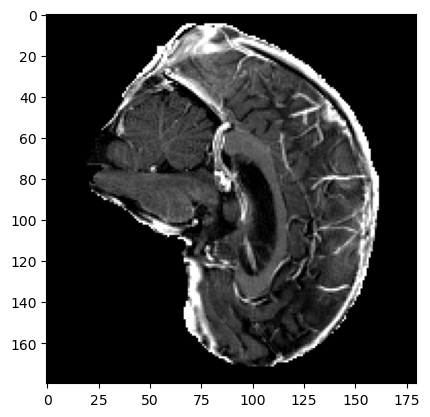

In [3]:
input, target = data.val_set[subj_idx]['image'][tio.DATA], data.val_set[subj_idx]['label']
# input = input.unsqueeze(0)
input = input.unsqueeze(0).to(device)
df = data.md_df_val
plt.imshow(input[0, 0, 90, :, :].cpu(), cmap='gray')
plt.show()

In [4]:
# prediction
network = network.to(device)
with torch.no_grad():
    output = network(input)
    # print(f"model's logits output: {output}")
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print(pred_label_idx, prediction_score)

model's logits output: tensor([[-0.4802, -0.1233]], device='cuda:0')
tensor([[1]], device='cuda:0') tensor([[0.5883]], device='cuda:0')


In [4]:
# prediction of all
network = network.to(device)
preds_final = []
for i in range(len(df)):
    input, target = data.val_set[subj_idx]['image'][tio.DATA], data.val_set[subj_idx]['label']
    print(df.iloc[i]['id'], target)
    input = input.unsqueeze(0).to(device)

    with torch.no_grad():
        output = network(input)
        # print(f"model's logits output: {output}")
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    print(pred_label_idx, prediction_score)
    preds_final.append([pred_label_idx.cpu().numpy()[0][0], prediction_score.cpu().numpy()[0][0]])
    break

sub-021 tensor([0., 1.])


OutOfMemoryError: CUDA out of memory. Tried to allocate 178.00 MiB (GPU 0; 11.76 GiB total capacity; 312.34 MiB already allocated; 49.50 MiB free; 332.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Reorient images so mapping can be done

In [54]:
def mask_maps(subject, save=True):
    anat_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks')
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    # read brain mask
    brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(anat_path/f'{subject}_brain_mask_mtsat_w.nii')))
    # # dilate the mask
    # brain_mask = binary_dilation(brain_mask, generate_binary_structure(3, 1), iterations=2).astype(brain_mask.dtype)

    x_min, x_max, y_min, y_max, z_min, z_max = crop_img(brain_mask, return_dims=True)

    # read atlas
    atlas = sitk.ReadImage(str(anat_path/f'inv_reoriented_{subject}_mT1w_PD_pd25_PD25-subcortical-1mm_uint8.nii'))
    atlas_nda = sitk.GetArrayFromImage(atlas)
    # crop atlas
    atlas_nda_c = atlas_nda[x_min:x_max, y_min:y_max, z_min:z_max] 
    if save:
        save_sitk_from_nda(atlas_nda_c,
                           anat_path/f'{subject}_PD25-subcortical-1mm_cropped.nii',
                           atlas)
    else:
        return atlas_nda_c
    # # process each map
    # for map_name in ['MTsat_w', 'PD_R2scorr_w', 'R1_w', 'R2s_WLS1_w']:
    #     sitk_map = sitk.ReadImage(str(pilot_path/f'{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map_name}.nii'))
    #     map_nda = sitk.GetArrayFromImage(sitk_map)
    #     # apply mask
    #     map_nda = map_nda * brain_mask
    #     # crop map
    #     map_nda_c = map_nda[x_min:x_max, y_min:y_max, z_min:z_max]
    #     # save map
    #     mask_dir = pilot_path/'brain_masked'
    #     mask_dir.mkdir(parents=True, exist_ok=True)
    #     save_sitk_from_nda(map_nda_c, 
    #                        mask_dir/f'{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map_name}.nii', 
    #                        sitk_map)

In [55]:
mask_maps('sub-015')

In [ ]:
import torchio as tio
subject = tio.Subject(
    chest_ct=tio.ScalarImage('subject_a_ct.nii.gz'),
    heart_mask=tio.LabelMap('subject_a_heart_seg.nii.gz'),
)
subject.chest_ct.shape
transform = tio.CropOrPad(
    (120, 80, 180),
    mask_name='heart_mask',
)
transformed = transform(subject)
transformed.chest_ct.shape

canonical_img = nib.as_closest_canonical(img)

In [4]:
pilot_path = Path("/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/sub-015/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01")
og_path = Path("/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/sub-015/Results/brain_masked")
# 1, reorient back to original orientation (reverse tio.ToCanonical)
img_og = nib.load(str(og_path/'sub-015_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii'))
img_can = nib.load(str(pilot_path/'sub-015_R2s_WLS1_ps5_stride3_og_img.nii.gz'))
pd25_path = og_path.parent / 'Masks/sub-015_PD25-subcortical-1mm_cropped.nii'
pd25_labs = nib.load(str(pd25_path))
print('Og')
print(img_og.affine)
print(nib.aff2axcodes(img_og.affine))
print('Can')
print(img_can.affine)
print(nib.aff2axcodes(img_can.affine))

Og
[[-2.80416306e-02 -6.56083235e-03  9.99585225e-01 -8.33101883e+01]
 [-9.73185291e-01  2.28571014e-01 -2.58007878e-02  7.79410858e+01]
 [ 2.28306934e-01  9.73505135e-01  1.27944095e-02 -1.83756454e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('P', 'S', 'R')
Can
[[-2.80416306e-02 -6.56083235e-03  9.99585225e-01 -8.33101883e+01]
 [-9.73185291e-01  2.28571014e-01 -2.58007878e-02  7.79410858e+01]
 [ 2.28306934e-01  9.73505135e-01  1.27944095e-02 -1.83756454e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('P', 'S', 'R')


In [5]:
preprocess = tio.Compose(
            [   tio.ToCanonical(),
                # tio.RescaleIntensity((0, 1)),
                tio.CropOrPad(180, 
                              padding_mode='minimum')
            ]
        )
# og_img_o = tio.Subject(image=tio.ScalarImage(og_path/'sub-015_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat_w.nii'))
atlas_tiosubj_o = tio.Subject(image=tio.ScalarImage(pd25_path))
atlas_tiosubj_p = preprocess(atlas_tiosubj_o)
# og_img_p = preprocess(og_img_o)
atlas_tiosubj_nda = atlas_tiosubj_p['image'][tio.DATA].cpu().numpy()[0]
img_can_nda = img_can.get_fdata()
type(img_can_nda)

numpy.ndarray

In [47]:
print(og_img_o['image']['affine'])
print(og_img_p['image']['affine'])
new_og_cropped_img = nib.Nifti1Image(og_img_p['image'][tio.DATA].cpu().numpy()[0], og_img_p['image']['affine'])
# new_atlas_cropped_img = nib.Nifti1Image(atlas_tiosubj_nda, atlas_tiosubj_p['image']['affine'])
nib.save(new_og_cropped_img, pilot_path/'new_brainmasked_MTsat_w.nii')
# nib.save(new_atlas_cropped_img, pilot_path/'new_atlas.nii')

[[-2.80416307e-02 -6.56083223e-03  9.99585225e-01 -8.33101883e+01]
 [-9.73185292e-01  2.28571012e-01 -2.58007873e-02  7.79410858e+01]
 [ 2.28306932e-01  9.73505135e-01  1.27944101e-02 -1.83756454e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99585225e-01  2.80416307e-02 -6.56083223e-03 -1.02383513e+02]
 [-2.58007873e-02  9.73185292e-01  2.28571012e-01 -1.01619180e+02]
 [ 1.27944101e-02 -2.28306932e-01  9.73505135e-01 -1.49943449e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [37]:
save_nifti_from_array(subj_id='sub-015',
                      arr=atlas_tiosubj_nda, 
                      path=pilot_path/'atlas_tiosubj_nda.nii.gz')

In [6]:
atlas_tiosubj_o['image']['affine']

array([[-1.57141559e-02,  5.40710365e-02,  9.98413436e-01,
        -9.05266113e+01],
       [-9.99876525e-01, -8.49792638e-04, -1.56911610e-02,
         1.45075119e+02],
       [-7.01125443e-09,  9.98536730e-01, -5.40777142e-02,
        -1.22689468e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [7]:
atlas_tiosubj_p['image']['affine']

array([[ 9.98413436e-01,  1.57141559e-02,  5.40710365e-02,
        -1.07812658e+02],
       [-1.56911610e-02,  9.99876525e-01, -8.49792638e-04,
        -3.76758105e+01],
       [-5.40777142e-02,  7.01125443e-09,  9.98536730e-01,
        -1.29920676e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [10]:
save_nifti_from_array(subj_id='sub-015', arr=atlas_tiosubj_nda,path=pilot_path/'atlas_cropped.nii')

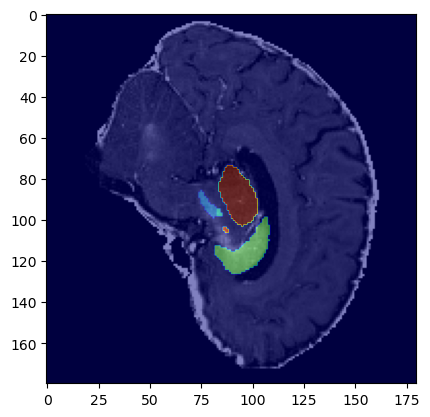

In [9]:
slice = 99
plt.figure()
plt.imshow(img_can_nda[slice, :, :], cmap='gray')
plt.imshow(atlas_tiosubj_nda[slice,:, :], cmap='jet', alpha=0.5)

### Oclussion-based attribution

In [51]:
occlusion = Occlusion(network)

attributions_occ = occlusion.attribute(input,
                                       strides = (1, 10, 10, 10),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1, 20, 20, 20),
                                       baselines=0)

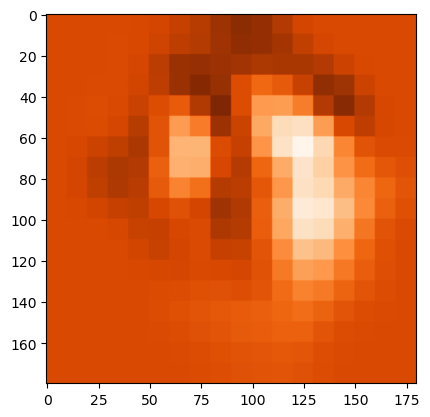

In [53]:
plt.imshow(attributions_occ[0, 0, 90, :, :].cpu(), cmap='Oranges')
plt.show()

In [55]:
attributions_occ.min()

tensor(-0.0137, device='cuda:0')

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

### Gradient-based

In [6]:
# integrated gradients
integrated_gradients = IntegratedGradients(network)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

# with noise tunnel
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.35 GiB (GPU 0; 11.76 GiB total capacity; 8.82 GiB already allocated; 354.94 MiB free; 9.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### LRP

In [9]:
dicky = None
if dicky is None:
    print('yeah')

yeah


In [7]:
lrp = LRP(network)
attributions_lrp = lrp.attribute(input, target=pred_label_idx)

TypeError: Module of type <class 'torch.nn.modules.conv.Conv3d'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

## Zennit

In [5]:
# LRP
from zennit.attribution import Gradient, SmoothGrad
from zennit.core import Stabilizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.composites import SpecialFirstLayerMapComposite, NameMapComposite
from zennit.image import imgify, imsave
from zennit.rules import Epsilon, ZPlus, ZBox, Norm, Pass, Flat
from zennit.types import Convolution, Activation, AvgPool, Linear as AnyLinear
from zennit.types import BatchNorm, MaxPool
from zennit.torchvision import VGGCanonizer, ResNetCanonizer

from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize

In [39]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(2)[[1]].to(device)

data_sample = copy.deepcopy(input).to(device).requires_grad_(True)

# create the attributor, specifying model and composite
with Gradient(model=network, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data_sample, target)

print(f'Prediction: {output.argmax(1)[0].item()}')
print(f'Attibution map shape: {attribution.shape}, min: {attribution.min()}, max: {attribution.max()}')

In [46]:
Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

tensor([[[[[-2.1179]],

          [[-2.0357]],

          [[-1.8044]]]],



        [[[[ 2.2489]],

          [[ 2.4286]],

          [[ 2.6400]]]]])

In [7]:
data_sample.shape

torch.Size([1, 1, 180, 180, 180])

In [8]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# the ZBox rule needs the lowest and highest values, which are here for
# ImageNet 0. and 1. with a different normalization for each channel
low = torch.zeros_like(data_sample, device=device, dtype=torch.float32)
high = torch.ones_like(data_sample, device=device, dtype=torch.float32)


# create a composite, specifying the canonizers, if any
composite = EpsilonGammaBox(low=low, high=high, canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(2)[[1]].to(device)

data_sample = copy.deepcopy(input).to(device)

# create the attributor, specifying model and composite
with Gradient(model=network, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data_sample, target)

print(f'Prediction: {output.argmax(1)[0].item()}')
print(f'Attibution map shape: {attribution.shape}, min: {attribution.min()}, max: {attribution.max()}')

Prediction: 1
Attibution map shape: torch.Size([1, 1, 180, 180, 180]), min: -0.0019344333559274673, max: 0.0023878365755081177


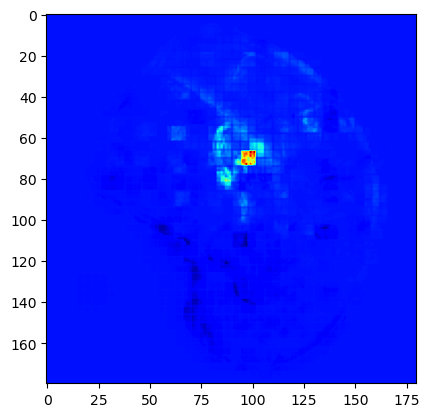

In [9]:
plt.imshow(attribution[0, 0, 90, :, :].detach().cpu(), cmap='jet')

In [10]:
# save the results
subj_id = df.iloc[subj_idx]['id']
out_dir = Path('/mrhome/alejandrocu/Documents/parkinson_classification/occ_sens/zennit_lrp') / Path(ckpt_path).parent.parent.parent.name
out_dir.mkdir(parents=True, exist_ok=True)
save_nifti_from_array(subj_id=subj_id,
                      arr=attribution[0, 0].cpu().detach().numpy(),
                      path=out_dir/f'{subj_id}_lrp_epsgammabox.nii.gz')